In [5]:
import  scipy.signal.signaltools
%matplotlib notebook

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import dtscalibration

In [6]:
import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook

from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
filepath = ''

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk


In [10]:
sections = {
    'probe1Temperature': [slice(130., 158.), slice(470., 500.)]
    }
ds.sections = sections

In [11]:
I_var, residuals = ds.variance_stokes_constant(st_label='st')
print("The variance of the Stokes signal along the reference sections "
      "is approximately {:.2f} on a {:.1f} sec acquisition time".format(I_var, ds.userAcquisitionTimeFW.data[0]))

The variance of the Stokes signal along the reference sections is approximately 0.13 on a 900.0 sec acquisition time


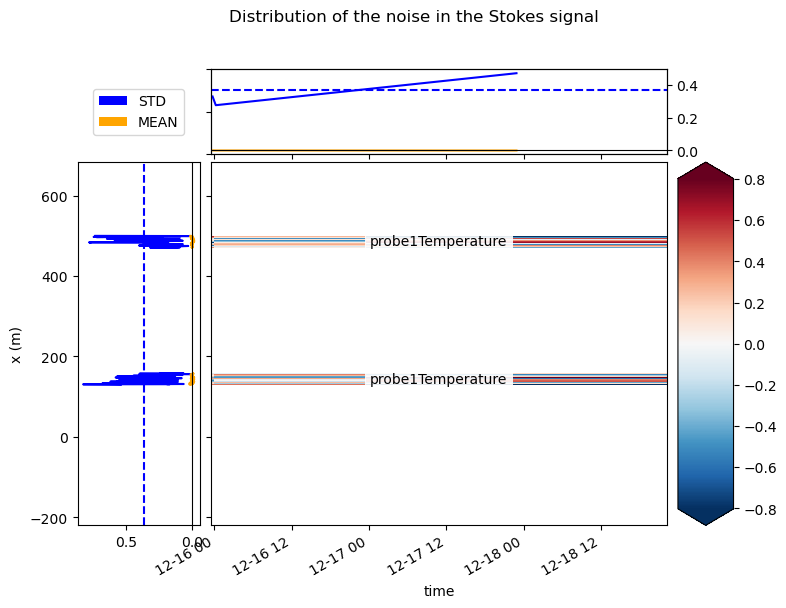

In [12]:
from dtscalibration import plot

fig_handle = plot.plot_residuals_reference_sections(
        residuals,
        sections,
        title='Distribution of the noise in the Stokes signal',
        plot_avg_std=I_var ** 0.5,
        plot_names=True,
        robust=True,
        units='',
        method='single')

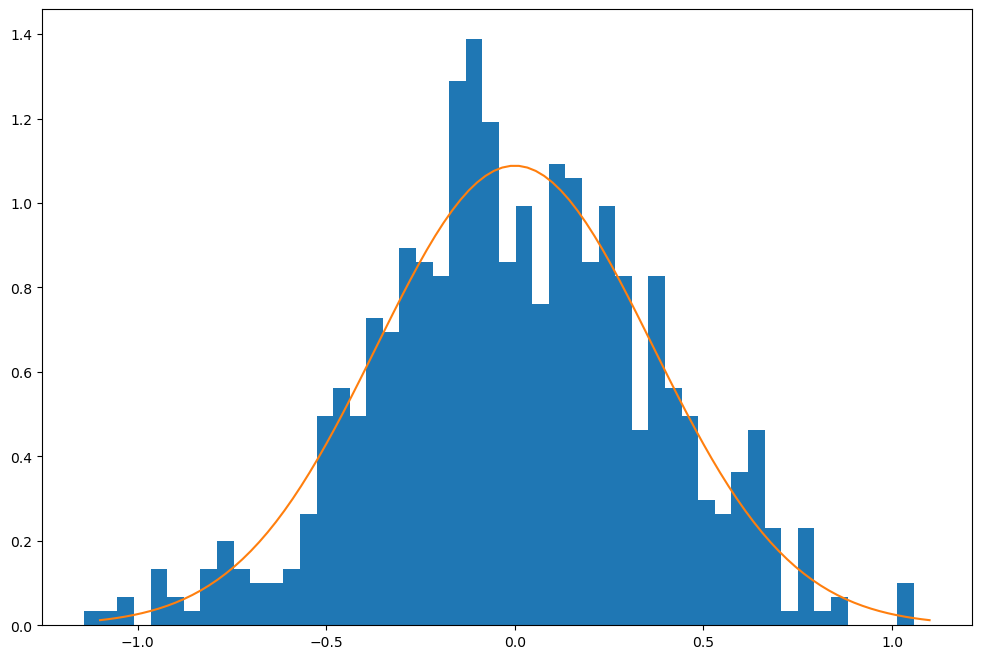

In [13]:
import scipy
import numpy as np

sigma = residuals.std()
mean = residuals.mean()
x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
approximated_normal_fit = scipy.stats.norm.pdf(x, mean, sigma)
residuals.plot.hist(bins=50, figsize=(12, 8), density=True)
plt.plot(x, approximated_normal_fit);

In [14]:
ds_borehole = ds.sel(x=slice(0, 630))  # only calibrate parts of the fiber

In [15]:
st_var, resid = ds_borehole.variance_stokes_constant(st_label='st')
ast_var, _ = ds_borehole.variance_stokes_constant(st_label='ast')
rst_var, _ = ds_borehole.variance_stokes_constant(st_label='rst')
rast_var, _ = ds_borehole.variance_stokes_constant(st_label='rast')

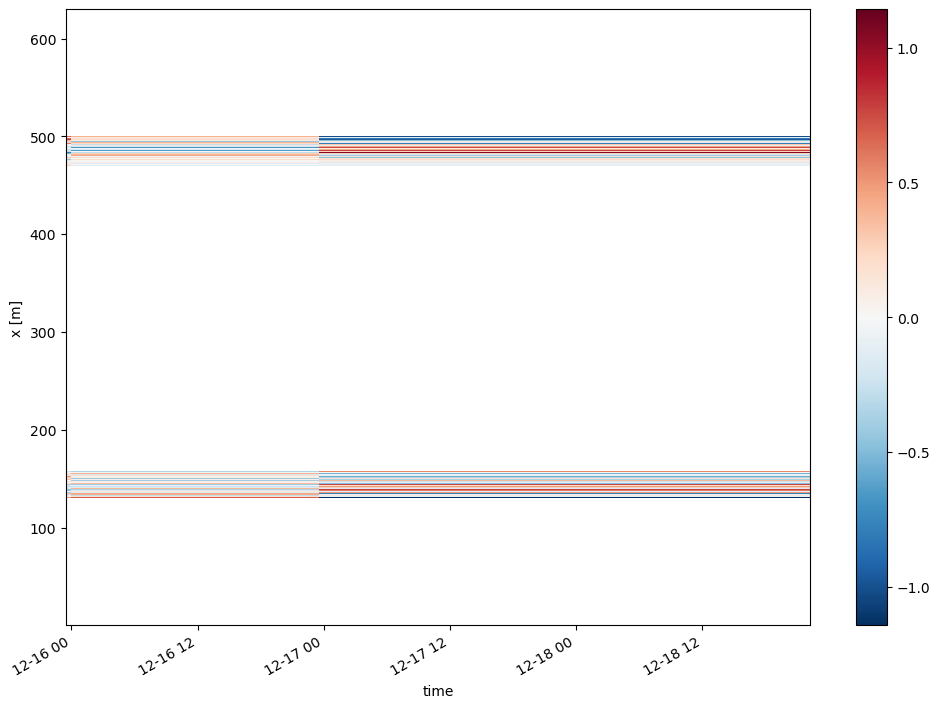

In [16]:
resid.plot(figsize=(12, 8));

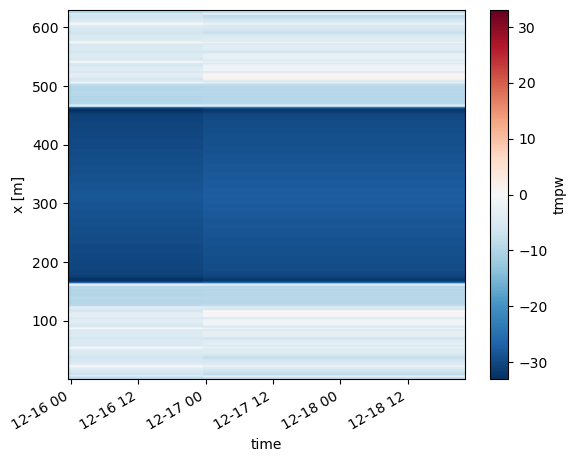

In [17]:
ds_borehole.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_borehole.tmpw.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


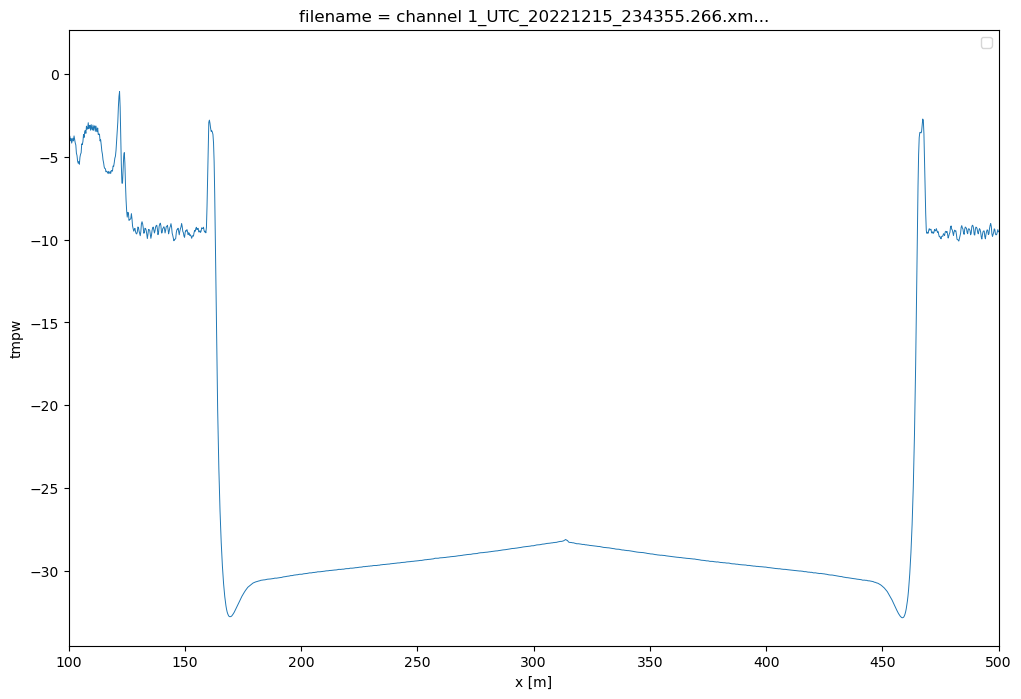

In [18]:
ds_borehole.conf_int_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 50., 97.5],
    mc_sample_size=500)  # <- choose a much larger sample size)

ds1 = ds_borehole.isel(time=-2)  # take only the first timestep
ds1.tmpw.plot(linewidth=0.7, figsize=(12, 8))
#ds1.tmpw_mc.isel(CI=0).plot(linewidth=0.7, label='CI: 2.5%')
#ds1.tmpw_mc.isel(CI=2).plot(linewidth=0.7, label='CI: 97.5%')
plt.xlim([100, 500])
#plt.ylim([-30,-25])
plt.legend();

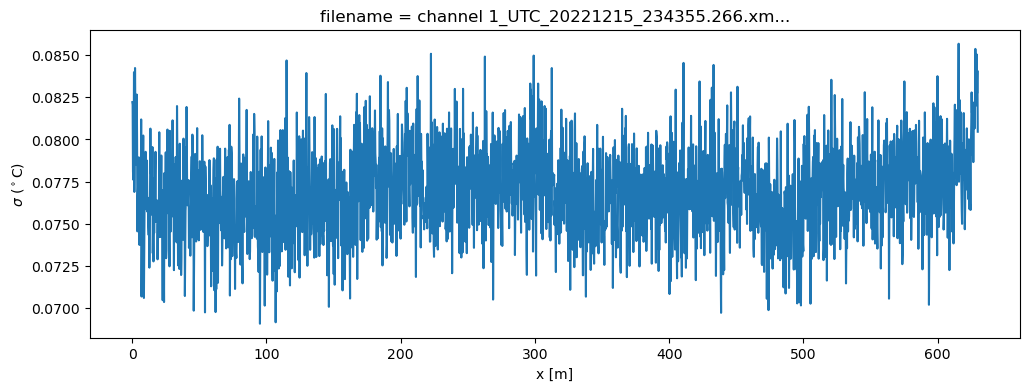

In [19]:
(ds1.tmpw_mc_var**0.5).plot(figsize=(12, 4));
plt.ylabel('$\sigma$ ($^\circ$C)');

In [32]:
ds1.tmp.x

<xarray.DataArray 'x' (x: 2478)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.29277e+02, 6.29531e+02,
       6.29785e+02])
Coordinates:
  * x                  (x) float64 0.133 0.388 0.642 0.896 ... 629.3 629.5 629.8
    filename           <U37 'channel 1_UTC_20221215_234355.266.xml'
    filename_tstamp    int64 20221215234355266
    timeFWstart        datetime64[ns] 2022-12-15T23:58:55.851000
    timeFWend          datetime64[ns] 2022-12-16T00:13:55.851000
    timeFW             datetime64[ns] 2022-12-16T00:06:25.851000
    timeBWstart        datetime64[ns] 2022-12-16T00:13:55.851000
    timeBWend          datetime64[ns] 2022-12-16T00:28:55.851000
    timeBW             datetime64[ns] 2022-12-16T00:21:25.851000
    timestart          datetime64[ns] 2022-12-15T23:58:55.851000
    timeend            datetime64[ns] 2022-12-16T00:28:55.851000
    time               datetime64[ns] 2022-12-16T00:13:55.851000
    acquisitiontimeFW  timedelta64[ns] 00:15:00
    acquisitiontimeBW  timedelta64[ns] 00:15:00
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m

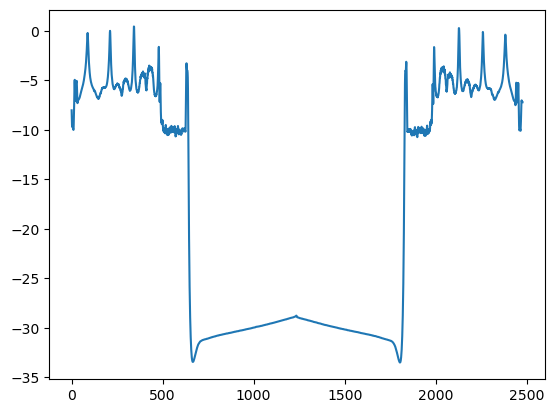

In [29]:
plt.plot(ds1.tmp.values)

<IPython.core.display.Javascript object>


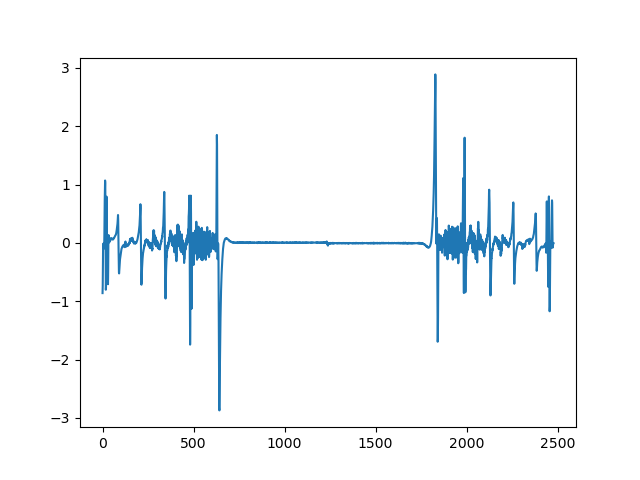

In [65]:
%matplotlib notebook
plt.plot(np.gradient(ds1.tmp.values))

In [62]:
# Program to calculate moving average
arr = np.gradient(ds1.tmp.values)
window_size = 2
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
  
# Loop through the array to consider
# every window of size 3
while i < len(arr) - window_size + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = arr[i : i + window_size]
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 4)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1
  

In [63]:
thermal_con = 2.5 #W/mK
q = np.asarray(moving_averages)*thermal_con*1000

<IPython.core.display.Javascript object>


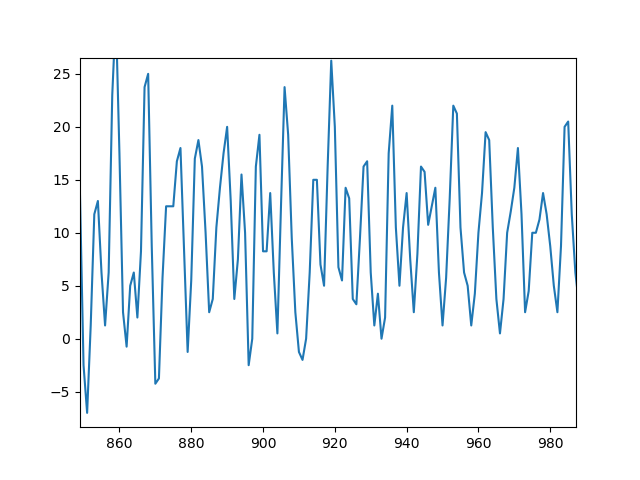

In [64]:
%matplotlib notebook
plt.plot(q)

In [ ]:
q = 

# Align the double ended fiber

<IPython.core.display.Javascript object>


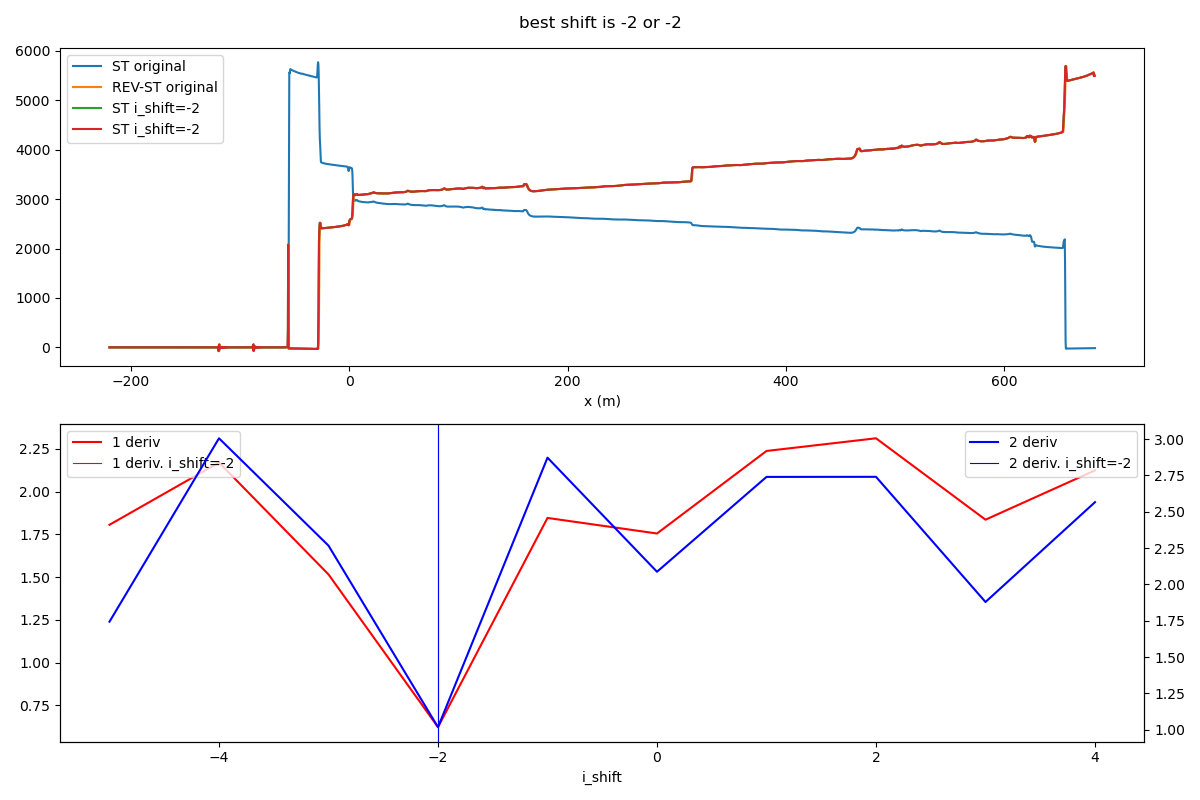

I dont know what to do with the following data ['tmp', 'alpha', 'alpha_var', 'tmpf', 'tmpb', 'tmpf_mc_var', 'tmpb_mc_var', 'tmpw', 'tmpw_mc_var', 'tmpf_avg1', 'tmpf_mc_avg1_var', 'tmpf_mc_avg1', 'tmpf_mc_avg2_var', 'tmpf_avg2', 'tmpf_mc_avg2', 'tmpb_avg1', 'tmpb_mc_avg1_var', 'tmpb_mc_avg1', 'tmpb_mc_avg2_var', 'tmpb_avg2', 'tmpb_mc_avg2', 'tmpw_avg2', 'tmpw_mc_avg2_var', 'tmpw_mc_avg2']
I dont know what to do with the following data ['tmp', 'alpha', 'alpha_var', 'tmpf', 'tmpb', 'tmpf_mc_var', 'tmpb_mc_var', 'tmpw', 'tmpw_mc_var', 'tmpf_avg1', 'tmpf_mc_avg1_var', 'tmpf_mc_avg1', 'tmpf_mc_avg2_var', 'tmpf_avg2', 'tmpf_mc_avg2', 'tmpb_avg1', 'tmpb_mc_avg1_var', 'tmpb_mc_avg1', 'tmpb_mc_avg2_var', 'tmpb_avg2', 'tmpb_mc_avg2', 'tmpw_avg2', 'tmpw_mc_avg2_var', 'tmpw_mc_avg2']


In [879]:
import os
from dtscalibration import read_silixa_files
from dtscalibration.datastore_utils import suggest_cable_shift_double_ended, shift_double_ended
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


suggested_shift = suggest_cable_shift_double_ended(
    ds,
    np.arange(-5, 5),
    plot_result=True,
    figsize=(12,8))



In [880]:
ds_restored = shift_double_ended(ds, suggested_shift[0])

print(ds.x, 3*'\n', ds_restored.x)

I dont know what to do with the following data ['tmp', 'alpha', 'alpha_var', 'tmpf', 'tmpb', 'tmpf_mc_var', 'tmpb_mc_var', 'tmpw', 'tmpw_mc_var', 'tmpf_avg1', 'tmpf_mc_avg1_var', 'tmpf_mc_avg1', 'tmpf_mc_avg2_var', 'tmpf_avg2', 'tmpf_mc_avg2', 'tmpb_avg1', 'tmpb_mc_avg1_var', 'tmpb_mc_avg1', 'tmpb_mc_avg2_var', 'tmpb_avg2', 'tmpb_mc_avg2', 'tmpw_avg2', 'tmpw_mc_avg2_var', 'tmpw_mc_avg2']
<xarray.DataArray 'x' (x: 3553)>
array([-219.749, -219.495, -219.241, ...,  682.658,  682.913,  683.167])
Coordinates:
  * x        (x) float64 -219.7 -219.5 -219.2 -219.0 ... 682.4 682.7 682.9 683.2
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m 


 <xarray.DataArray 'x' (x: 3551)>
array([-219.749, -219.495, -219.241, ...,  682.15 ,  682.404,  682.658])
Coordinates:
  * x        (x) float64 -219.7 -219.5 -219.2 -219.0 ... 681.9 682.1 682.4 682.7
Attributes:
    name:         

In [881]:
ds_restored

<dtscalibration.DataStore>
Sections:
    probe1Temperature      ( -9.78 +/- 0.54°C)	129.00 - 159.00 and 469.00 - 499.00
Dimensions:                (time: 3, params1: 3560, params2: 3560, x: 3551, trans_att: 0)
Coordinates: (12/15)
    filename               (time) <U37 'channel 1_UTC_20221215_231353.319.xml...
    filename_tstamp        (time) int64 20221215231353319 ... 20221217222408136
    timeFWstart            (time) datetime64[ns] 2022-12-15T23:28:53.657000 ....
    timeFWend              (time) datetime64[ns] 2022-12-15T23:43:53.657000 ....
    timeFW                 (time) datetime64[ns] 2022-12-15T23:36:23.657000 ....
    timeBWstart            (time) datetime64[ns] 2022-12-15T23:43:53.657000 ....
    ...                     ...
    timeend                (time) datetime64[ns] 2022-12-15T23:58:53.657000 ....
  * time                   (time) datetime64[ns] 2022-12-15T23:43:53.657000 ....
    acquisitiontimeFW      (time) timedelta64[ns] 00:15:00 00:15:00 00:15:00
    acquisitiontimeBW      (time) timedelta64[ns] 00:15:00 00:15:00 00:15:00
  * x                      (x) float64 -219.7 -219.5 -219.2 ... 682.4 682.7
  * trans_att              (trans_att) float64 
Dimensions without coordinates: params1, params2
Data variables: (12/21)
    acquisitionTime        (time) float32 1.8e+03 1.801e+03 1.8e+03
    referenceTemperature   (time) float32 -9.237 -7.18 -7.759
    probe1Temperature      (time) float32 -10.53 -9.503 -9.299
    probe2Temperature      (time) float32 -10.93 -10.14 -12.04
    referenceProbeVoltage  (time) float32 0.0 0.0 0.0
    probe1Voltage          (time) float32 0.0 0.0 0.0
    ...                     ...
    p_val                  (params1) float64 485.0 1.673 ... 0.003028 0.03869
    p_cov                  (params1, params2) float64 1.16e-12 ... 0.002409
    st                     (x, time) float64 0.01046 -0.0278 ... -15.79 -16.98
    ast                    (x, time) float64 0.02944 0.02333 ... -14.12 -14.53
    rst                    (x, time) float64 0.0009231 -0.01307 ... 5.101e+03
    rast                   (x, time) float64 -0.02755 -0.07248 ... 4.149e+03
Attributes: (12/367)
    uid:                                                                     ...
    nameWell:                                                                ...
    nameWellbore:                                                            ...
    name:                                                                    ...
    indexType:                                                               ...
    startIndex:uom:                                                          ...
    ...                                                                                                                                                    ...
    customData:UserConfiguration:ChannelConfiguration_3:FibreCorrectionConfig...
    customData:UserConfiguration:ChannelConfiguration_3:FibreCorrectionConfig...

.. and many more attributes. See: ds.attrs

In [69]:
## Now plot the new alignment

In [882]:
ds_borehole = ds_restored.sel(x=slice(0, 630))  # only calibrate parts of the fiber

<IPython.core.display.Javascript object>


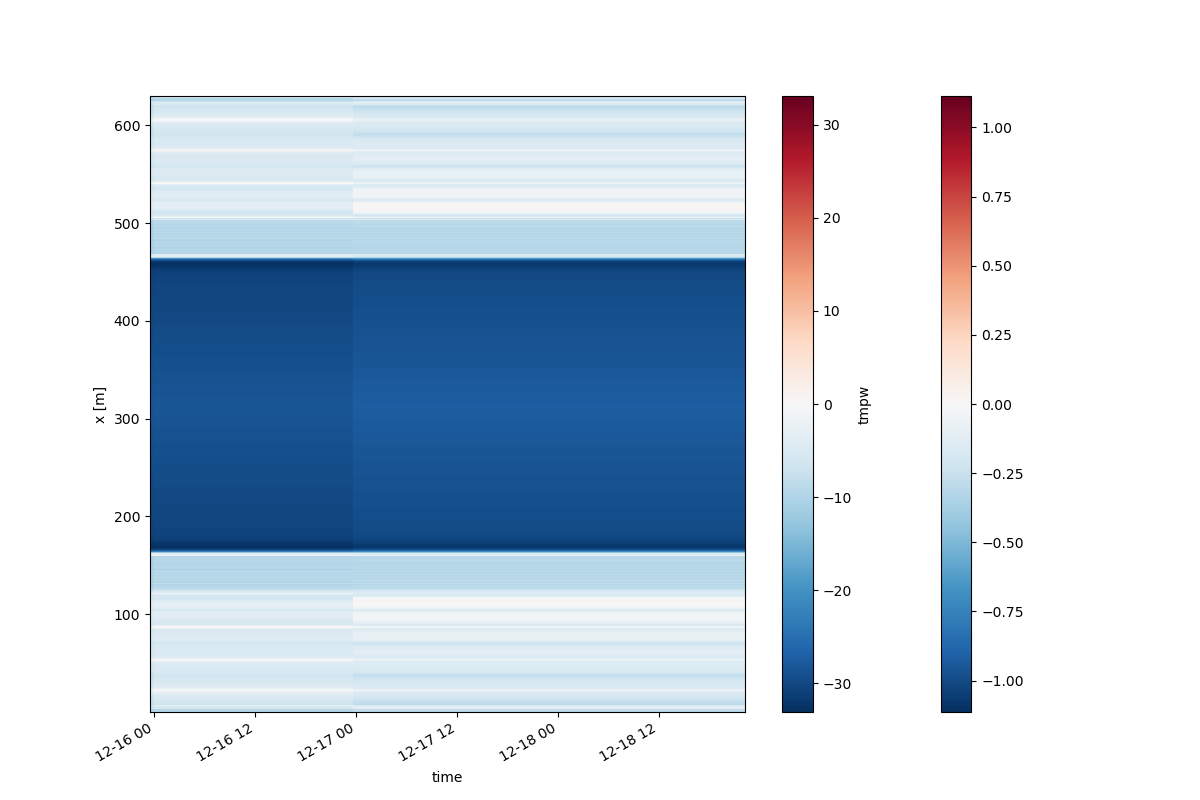

In [883]:
st_var, resid = ds_borehole.variance_stokes_constant(st_label='st')
ast_var, _ = ds_borehole.variance_stokes_constant(st_label='ast')
rst_var, _ = ds_borehole.variance_stokes_constant(st_label='rst')
rast_var, _ = ds_borehole.variance_stokes_constant(st_label='rast')

resid.plot(figsize=(12, 8));

In [884]:
ds_borehole.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_borehole.tmpw.plot()

<IPython.core.display.Javascript object>


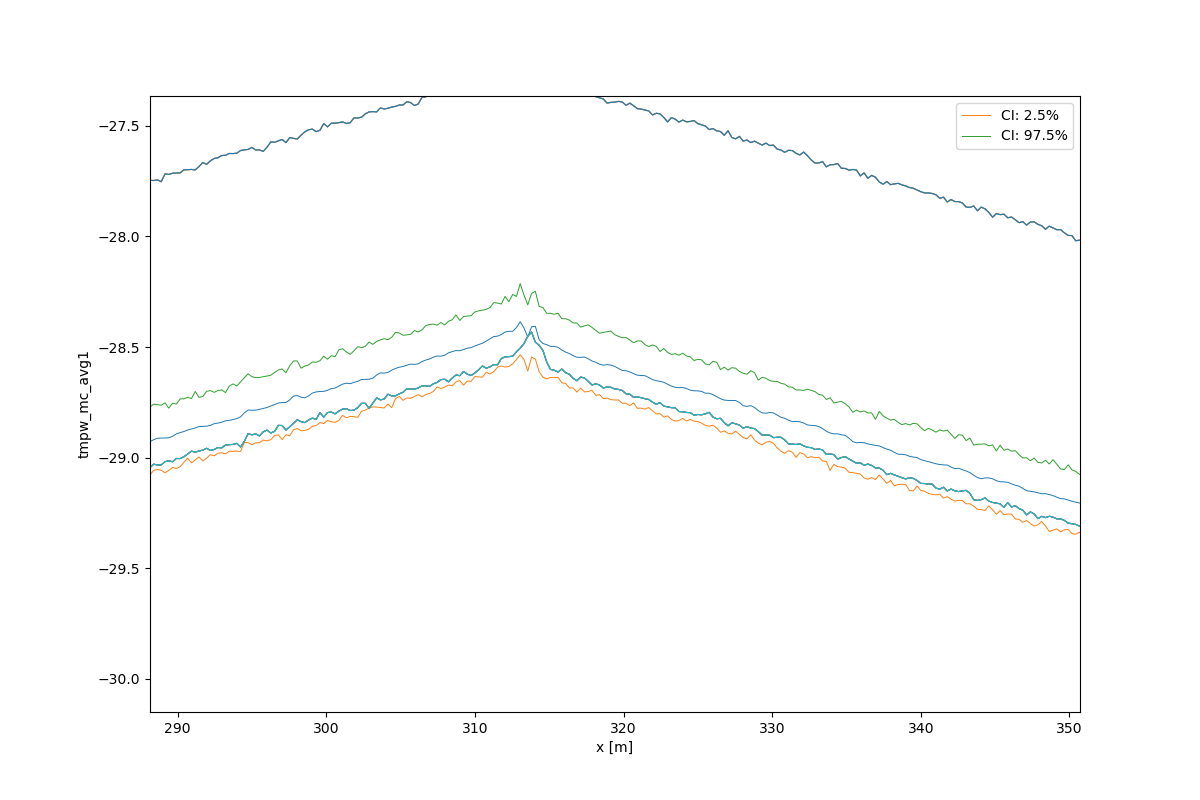

In [73]:
ds_borehole.conf_int_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 50., 97.5],
    mc_sample_size=500)  # <- choose a much larger sample size)

ds1 = ds_borehole.isel(time=-3)  # take only the first timestep
ds1.tmpw.plot(linewidth=0.7, figsize=(12, 8))
ds1.tmpw_mc.isel(CI=0).plot(linewidth=0.7, label='CI: 2.5%')
ds1.tmpw_mc.isel(CI=2).plot(linewidth=0.7, label='CI: 97.5%')
plt.legend();

In [163]:
## Thermistor ##

import pandas as pd

thermistor = pd.read_csv('Temp Logging Data Allan Hills.csv')
print(thermistor)

    Temp (23-Dec)  Temp (07-Jan)   Depth
0          -17.06         -14.04    0.35
1          -33.23         -31.83    5.00
2          -33.63         -33.61   10.00
3          -32.55         -32.61   15.00
4          -32.20         -32.27   20.00
5          -32.09         -32.07   25.00
6          -31.96         -32.03   30.00
7          -31.76            NaN   40.00
8          -31.60         -31.59   50.00
9          -31.44            NaN   60.00
10         -31.28         -31.34   70.00
11         -31.12            NaN   80.00
12         -30.94         -30.96   90.00
13         -30.76            NaN  100.00
14         -30.58         -30.64  110.00
15         -30.38            NaN  120.00
16         -30.18         -30.21  130.00
17         -29.98         -30.02  140.00
18         -29.86         -29.90  148.75


In [878]:
ds1.tmpw.as_numpy()[100:800]

<xarray.DataArray 'tmpw' (x: 700)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,  6.19594537e+00,
                   nan,             nan,             nan, -6.26755031e+01,
                   nan,             nan,             nan,             nan,
        4.41575162e+01,             nan,             nan,             nan,
                   nan,             nan, -8.70832464e+01,             nan,
                   nan, -4.11983857e+01, -1.01955723e+02,  1.53953867e+02,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  9.30819957e+01, -4.68258473e+01,             nan,
                   nan,             nan, -8.22629280e+01,             nan,
                   nan,  1.12467456e+03,             nan,             nan,
                   nan, -3.29731341e+01,             nan,             nan,
                   nan,  1.35263396e+02,  3.69397071e+02,             nan,
                   nan, -1.71406258e+02,             nan,             nan,
        2.92613637e+01,             nan,             nan,             nan,
                   nan, -8.40281590e+01,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  8.44679049e+02,             nan,             nan,
...
       -1.27620454e+01, -1.28481405e+01, -1.25120898e+01, -1.29071879e+01,
       -1.24669168e+01, -1.30400007e+01, -1.26354567e+01, -1.27862138e+01,
       -1.27246336e+01, -1.23785825e+01, -1.29280152e+01, -1.22096649e+01,
       -1.29899632e+01, -1.21764758e+01, -1.28629272e+01, -1.23938446e+01,
       -1.22297119e+01, -1.28266734e+01, -1.19136435e+01, -1.31022206e+01,
       -1.13375682e+01, -1.26905817e+01, -1.17407878e+01, -1.22311408e+01,
       -1.28540642e+01, -1.21494837e+01, -1.19422983e+01, -8.20941701e+00,
       -1.44259162e+01, -6.15732186e+00, -1.18763498e+01, -6.65352931e+01,
       -1.03707293e+01, -2.31171050e+01, -1.79464782e+01, -1.25676241e+01,
       -1.03316455e+01, -8.93332800e+00, -8.52360842e+00, -8.97114878e+00,
       -9.04648377e+00, -8.90490009e+00, -8.89020228e+00, -8.95710402e+00,
       -8.98699062e+00, -8.98146097e+00, -8.97617880e+00, -8.96668337e+00,
       -8.96108030e+00, -8.94690925e+00, -8.94410794e+00, -8.93474210e+00,
       -8.92799852e+00, -8.92156861e+00, -8.92059768e+00, -8.92187988e+00,
       -8.92205557e+00, -8.92613422e+00, -8.92421547e+00, -8.91319353e+00,
       -8.90110325e+00, -8.90451120e+00, -8.89841384e+00, -8.89213862e+00,
       -8.89055639e+00, -8.89101034e+00, -8.88832659e+00, -8.88743760e+00,
       -8.88189463e+00, -8.87183985e+00, -8.87482049e+00, -8.86999279e+00,
       -8.86841708e+00, -8.87090409e+00, -8.86714142e+00, -8.86027904e+00,
       -8.85703269e+00, -8.85883120e+00, -8.85857470e+00, -8.85829257e+00])
Coordinates:
    filename           <U37 'channel 1_UTC_20221215_231353.319.xml'
    filename_tstamp    int64 20221215231353319
    timeFWstart        datetime64[ns] 2022-12-15T23:28:53.657000
    timeFWend          datetime64[ns] 2022-12-15T23:43:53.657000
    timeFW             datetime64[ns] 2022-12-15T23:36:23.657000
    timeBWstart        datetime64[ns] 2022-12-15T23:43:53.657000
    timeBWend          datetime64[ns] 2022-12-15T23:58:53.657000
    timeBW             datetime64[ns] 2022-12-15T23:51:23.657000
    timestart          datetime64[ns] 2022-12-15T23:28:53.657000
    timeend            datetime64[ns] 2022-12-15T23:58:53.657000
    time               datetime64[ns] 2022-12-15T23:43:53.657000
    acquisitiontimeFW  timedelta64[ns] 00:15:00
    acquisitiontimeBW  timedelta64[ns] 00:15:00
  * x                  (x) float64 -194.3 -194.1 -193.8 ... -17.15 -16.9 -16.64

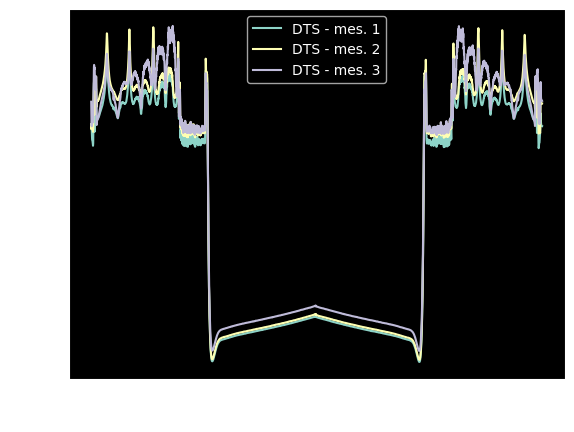

In [901]:



ds1 = ds_borehole.isel(time=-3)
ds2 = ds_borehole.isel(time=-2)
ds3 = ds_borehole.isel(time=-1)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
#plt.style.use('dark_background')
ax.plot(ds1.tmpw, label = 'DTS - mes. 1')
ax.plot(ds2.tmpw, label = 'DTS - mes. 2')
ax.plot(ds3.tmpw, label = 'DTS - mes. 3')
#ax.plot(thermistor['Temp (23-Dec)'], thermistor['Depth'], label = 'Thermistor-1')

ax.set_xlabel('Optical Distance (m)')
ax.set_ylabel('Temperature (C)')
plt.legend()

#ax.invert_yaxis()
plt.show()
#fig.savefig('DTS_borehole_mes_AllanHills.png', dpi=600)

# Calibration using matching sections

In [905]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

In [906]:
filepath = ''

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 628))  # only calibrate parts of the fiber


sections = {
    'probe1Temperature': [slice(130., 158.)],  # temp isolator
    }
ds.sections = sections

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk


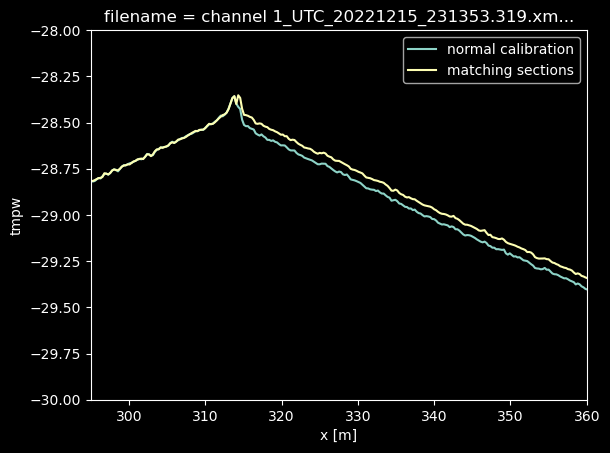

In [913]:
%matplotlib inline

matching_sections = [
    (slice(130., 158.), slice(470.5, 498.75), False)
]

st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    trans_att=[314.25],
    matching_sections=matching_sections,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_a.isel(time=0).tmpw.plot(label='normal calibration')
ds.isel(time=0).tmpw.plot(label='matching sections')
plt.xlim([295,360])
plt.ylim([-30,-28])
plt.legend()

In [19]:
## This doesn't do much it seems.

# Average over time while temperature varies over time and along fiber

In [200]:
ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

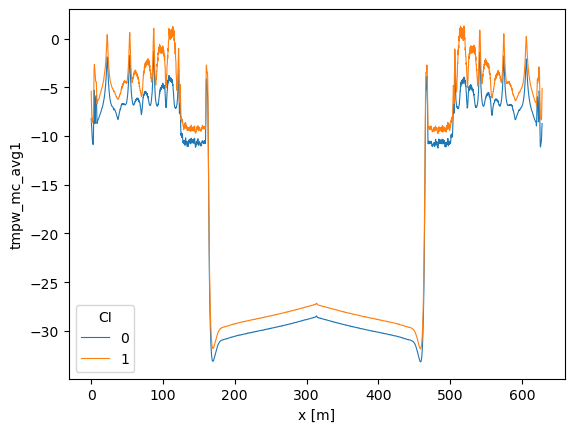

In [201]:
ds.average_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500,  # <- choose a much larger sample size
    ci_avg_time_flag1=True,
    ci_avg_time_flag2=False,
    ci_avg_time_isel=[0, 1, 2],
    ci_avg_time_sel=None)
ds.tmpw_mc_avg1.plot(hue='CI', linewidth=0.8);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


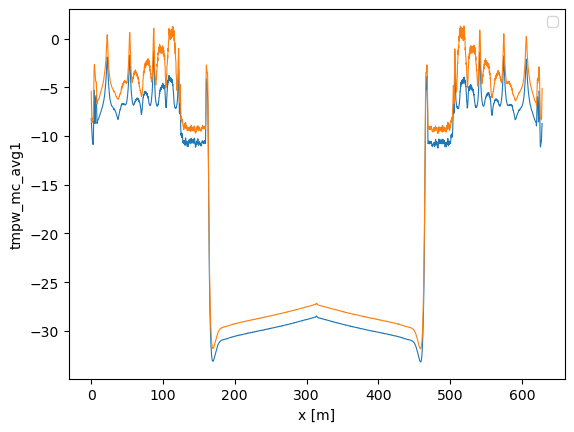

In [202]:
ds.tmpw_mc_avg1.plot(hue='CI', linewidth=0.8)
plt.legend();

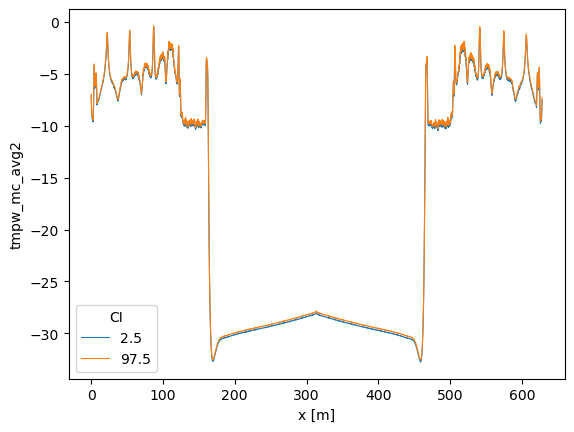

In [209]:
ds.average_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500,  # <- choose a much larger sample size
    ci_avg_time_flag1=False,
    ci_avg_time_flag2=True,
    ci_avg_time_isel=[0, 1, 2],
    ci_avg_time_sel=None)
ds.tmpw_mc_avg2.plot(hue='CI', linewidth=0.8);

Estimation of linear variance of st Adjusting nbin to: 37


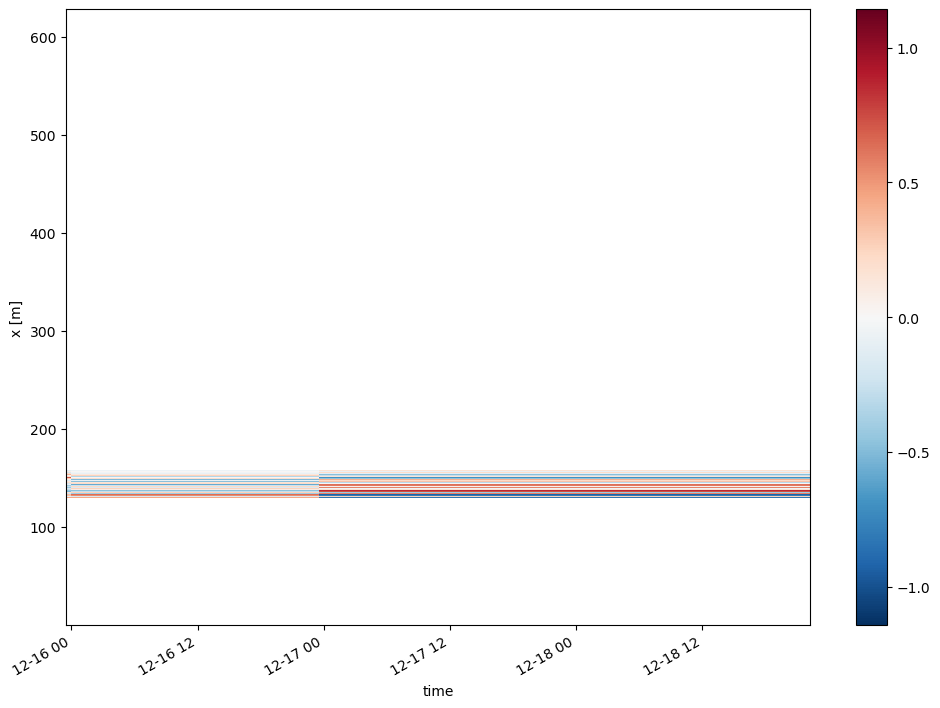

In [212]:
slope, offset, st_sort_mean, st_sort_var, resid, var_fun = ds.variance_stokes_linear(st_label = 'st')
resid.plot(figsize=(12, 8));

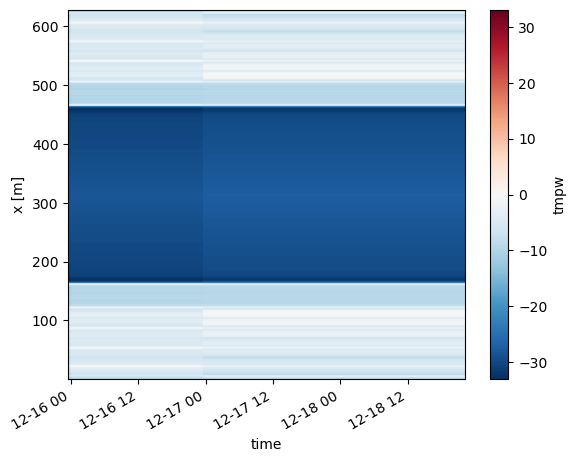

In [205]:
ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds.tmpw.plot()

In [206]:
ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds.conf_int_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=1000)  # <- choose a much larger sample size)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


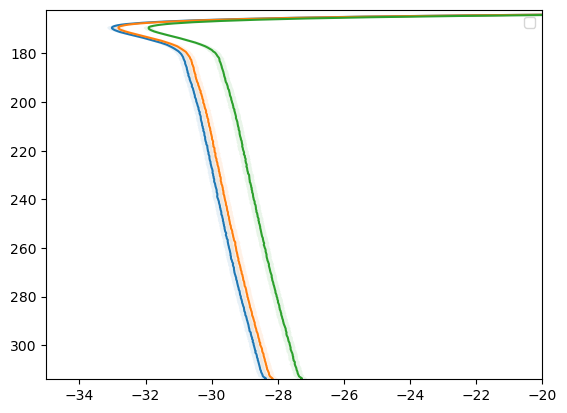

In [207]:
ds1 = ds.isel(time=0)  # take only the first timestep
ds2 = ds.isel(time=1)  # take only the first timestep
ds3 = ds.isel(time=2)  # take only the first timestep

fig, ax = plt.subplots()


ax.fill_betweenx(ds1.tmpw.x, ds1.tmpw_mc.isel(CI=0), ds1.tmpw_mc.isel(CI=1), alpha=.1)
ax.plot(ds1.tmpw, ds1.tmpw.x)
#ds1.tmpw.plot(orientation = 'vertical')

ax.fill_betweenx(ds2.tmpw.x, ds2.tmpw_mc.isel(CI=0), ds2.tmpw_mc.isel(CI=1), alpha=.1)
ax.plot(ds2.tmpw, ds2.tmpw.x)
#ds2.tmpw.plot(orientation = 'vertical')

ax.fill_betweenx(ds3.tmpw.x, ds3.tmpw_mc.isel(CI=0), ds3.tmpw_mc.isel(CI=1), alpha=.1)
ax.plot(ds3.tmpw, ds3.tmpw.x)
#ds3.tmpw.plot(orientation = 'vertical')

plt.gca().invert_yaxis()

plt.ylim([314,162])
plt.xlim([-35,-20])
plt.legend();

# Averaging over time while assuming the temperature remains constant over time but varies along the fiber

'I want to estimate a background temperature with confidence intervals. I hereby assume the temperature does not change over time and average all measurements to get a better estimate of the background temperature.'

In [233]:
filepath = ''

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_  # only calibrate parts of the fiber
sections = {
    'probe1Temperature': [slice(129., 159.), slice(469., 499.)],  # isolator
    }
ds.sections = sections

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk


### shift the dataset for proper double ended alignment

<IPython.core.display.Javascript object>


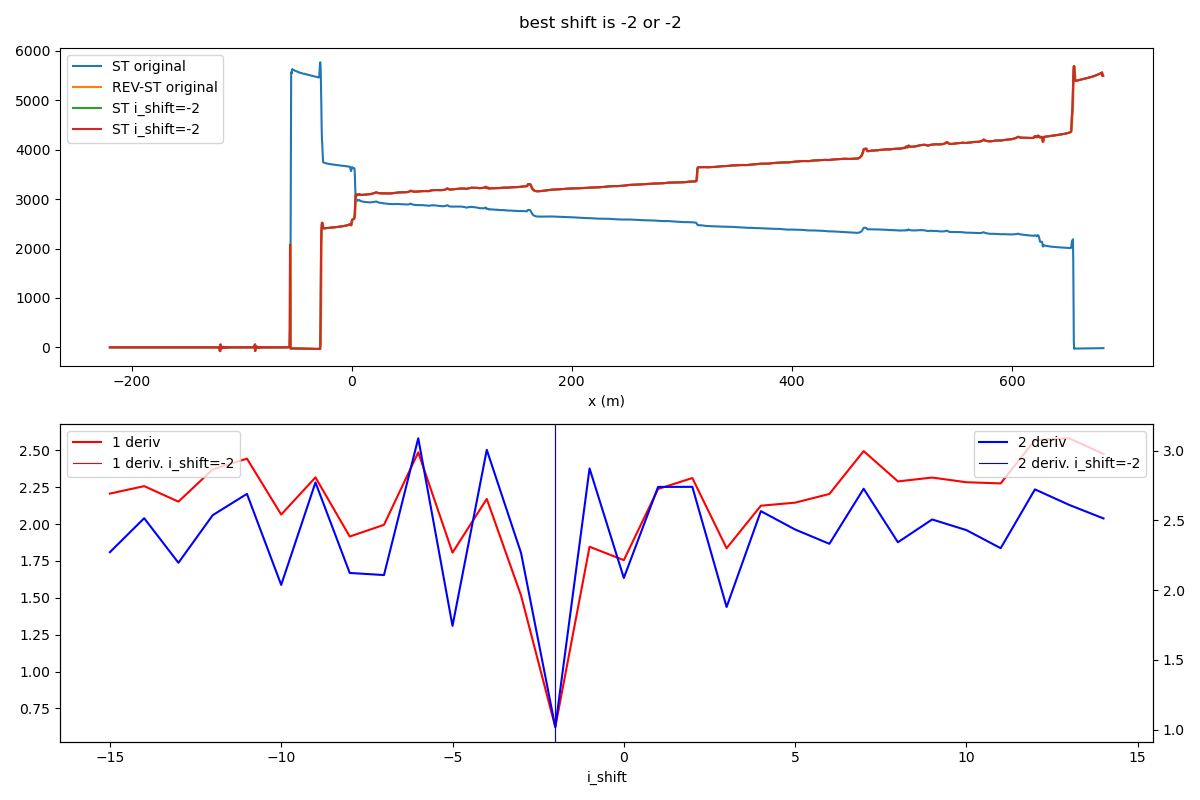

I dont know what to do with the following data ['tmp', 'alpha', 'alpha_var', 'tmpf', 'tmpb', 'tmpf_mc_var', 'tmpb_mc_var', 'tmpw', 'tmpw_mc_var', 'tmpf_avg1', 'tmpf_mc_avg1_var', 'tmpf_mc_avg1', 'tmpf_mc_avg2_var', 'tmpf_avg2', 'tmpf_mc_avg2', 'tmpb_avg1', 'tmpb_mc_avg1_var', 'tmpb_mc_avg1', 'tmpb_mc_avg2_var', 'tmpb_avg2', 'tmpb_mc_avg2', 'tmpw_avg2', 'tmpw_mc_avg2_var', 'tmpw_mc_avg2']
I dont know what to do with the following data ['tmp', 'alpha', 'alpha_var', 'tmpf', 'tmpb', 'tmpf_mc_var', 'tmpb_mc_var', 'tmpw', 'tmpw_mc_var', 'tmpf_avg1', 'tmpf_mc_avg1_var', 'tmpf_mc_avg1', 'tmpf_mc_avg2_var', 'tmpf_avg2', 'tmpf_mc_avg2', 'tmpb_avg1', 'tmpb_mc_avg1_var', 'tmpb_mc_avg1', 'tmpb_mc_avg2_var', 'tmpb_avg2', 'tmpb_mc_avg2', 'tmpw_avg2', 'tmpw_mc_avg2_var', 'tmpw_mc_avg2']


In [238]:
suggested_shift = suggest_cable_shift_double_ended(
    ds,
    np.arange(-15, 15),
    plot_result=True,
    figsize=(12,8))

In [239]:
ds_restored = shift_double_ended(ds, suggested_shift[0])

print(ds.x, 3*'\n', ds_restored.x)

ds_borehole = ds_restored.sel()  # only calibrate parts of the fiber

I dont know what to do with the following data ['tmp', 'alpha', 'alpha_var', 'tmpf', 'tmpb', 'tmpf_mc_var', 'tmpb_mc_var', 'tmpw', 'tmpw_mc_var', 'tmpf_avg1', 'tmpf_mc_avg1_var', 'tmpf_mc_avg1', 'tmpf_mc_avg2_var', 'tmpf_avg2', 'tmpf_mc_avg2', 'tmpb_avg1', 'tmpb_mc_avg1_var', 'tmpb_mc_avg1', 'tmpb_mc_avg2_var', 'tmpb_avg2', 'tmpb_mc_avg2', 'tmpw_avg2', 'tmpw_mc_avg2_var', 'tmpw_mc_avg2']
<xarray.DataArray 'x' (x: 3553)>
array([-219.749, -219.495, -219.241, ...,  682.658,  682.913,  683.167])
Coordinates:
  * x        (x) float64 -219.7 -219.5 -219.2 -219.0 ... 682.4 682.7 682.9 683.2
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m 


 <xarray.DataArray 'x' (x: 3551)>
array([-219.749, -219.495, -219.241, ...,  682.15 ,  682.404,  682.658])
Coordinates:
  * x        (x) float64 -219.7 -219.5 -219.2 -219.0 ... 681.9 682.1 682.4 682.7
Attributes:
    name:         

In [240]:
st_var, resid = ds_borehole.variance_stokes(st_label='st')
ast_var, _ = ds_borehole.variance_stokes(st_label='ast')
rst_var, _ = ds_borehole.variance_stokes(st_label='rst')
rast_var, _ = ds_borehole.variance_stokes(st_label='rast')

In [241]:
ds_borehole.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

<IPython.core.display.Javascript object>


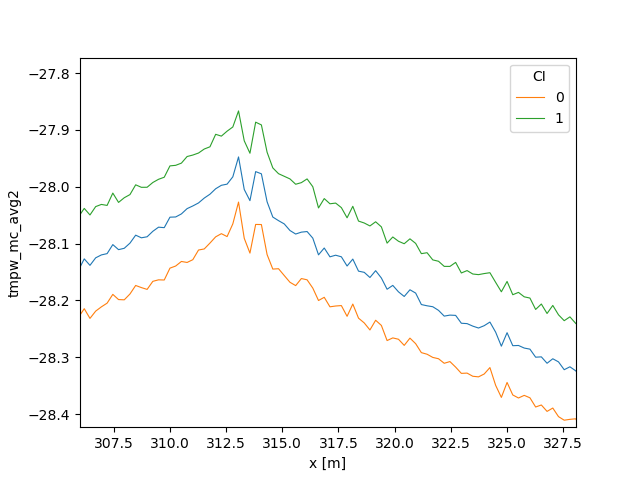

In [242]:
%matplotlib notebook

ds_borehole.average_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=1000,  # <- choose a much larger sample size
    ci_avg_time_flag1=False,
    ci_avg_time_flag2=True,
    ci_avg_time_isel=[0, 1, 2],
    ci_avg_time_sel=None)
ds_borehole.tmpw_avg2.plot(linewidth=0.8)
ds_borehole.tmpw_mc_avg2.plot(hue='CI', linewidth=0.8);

<IPython.core.display.Javascript object>


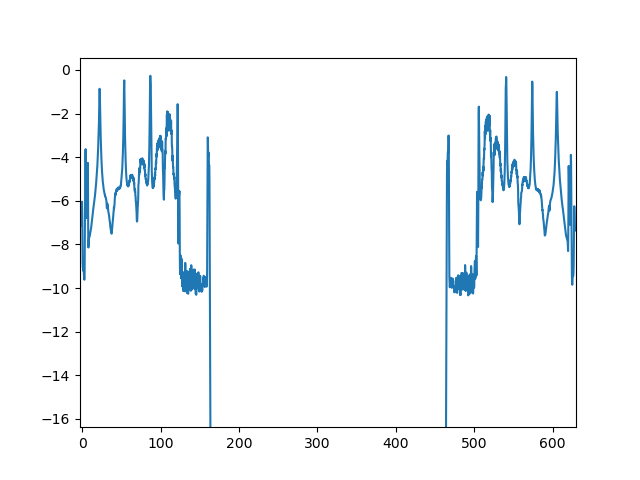

In [243]:
fig, ax = plt.subplots()


ax.plot(ds_borehole.tmpw_mc_avg2.x, ds_borehole.tmpw_avg2)


In [276]:
ds_borehole_only = ds_borehole.sel(x=slice(163, 313))

In [277]:
thermistor

,Temp (23-Dec),Temp (07-Jan),Depth
0,-17.06,-14.04,0.35
1,-33.23,-31.83,5.00
2,-33.63,-33.61,10.00
3,-32.55,-32.61,15.00
4,-32.20,-32.27,20.00
5,-32.09,-32.07,25.00
6,-31.96,-32.03,30.00
7,-31.76,NaN,40.00
8,-31.60,-31.59,50.00
9,-31.44,NaN,60.00


<IPython.core.display.Javascript object>


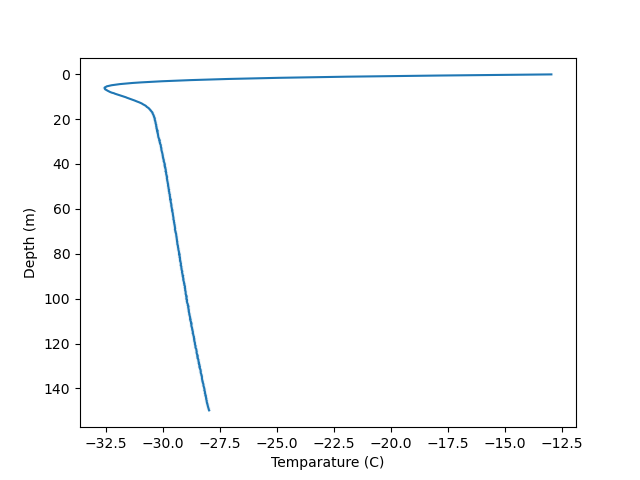

In [285]:
fig, ax = plt.subplots()


ax.fill_betweenx(ds_borehole_only.x - 163, ds_borehole_only.tmpw_mc_avg2.isel(CI=0), ds_borehole_only.tmpw_mc_avg2.isel(CI=1), alpha=.1)
ax.plot(ds_borehole_only.tmpw_avg2, ds_borehole_only.tmpw_avg2.x - 163)
#ax.plot(thermistor['Temp (23-Dec)'], thermistor['Depth'])

plt.gca().invert_yaxis()

ax.set_ylabel('Depth (m)')
ax.set_xlabel('Temparature (C)')

plt.show()

In [309]:
ds1 = ds_borehole.isel(time = 0)
ds2 = ds_borehole.isel(time = 1)
ds3 = ds_borehole.isel(time = 2)

In [330]:
ds1_slice_0 = ds1.sel(x=slice(163, 313.7))
ds2_slice_0 = ds2.sel(x=slice(163, 313.7))
ds3_slice_0 = ds3.sel(x=slice(163, 313.7))
ds1_slice_1 = ds1.sel(x=slice(313.7, 464.2))
ds2_slice_1 = ds2.sel(x=slice(313.7, 464.2))
ds3_slice_1 = ds3.sel(x=slice(313.7, 464.2))

In [313]:
ds1_mean = np.mean(ds1_slice.tmpw)
ds2_mean = np.mean(ds2_slice.tmpw)
ds3_mean = np.mean(ds3_slice.tmpw)

ds1_std = np.std(ds1_slice.tmpw)
ds2_std = np.std(ds2_slice.tmpw)
ds3_std = np.std(ds3_slice.tmpw)

ds1_norm = (ds1_slice.tmpw - ds1_mean) / ds1_std
ds2_norm = (ds2_slice.tmpw - ds2_mean) / ds2_std
ds3_norm = (ds1_slice.tmpw - ds3_mean) / ds3_std

fig, ax = plt.subplots()

ax.plot(ds1_norm)
ax.plot(ds2_norm)
ax.plot(ds3_norm)

<IPython.core.display.Javascript object>


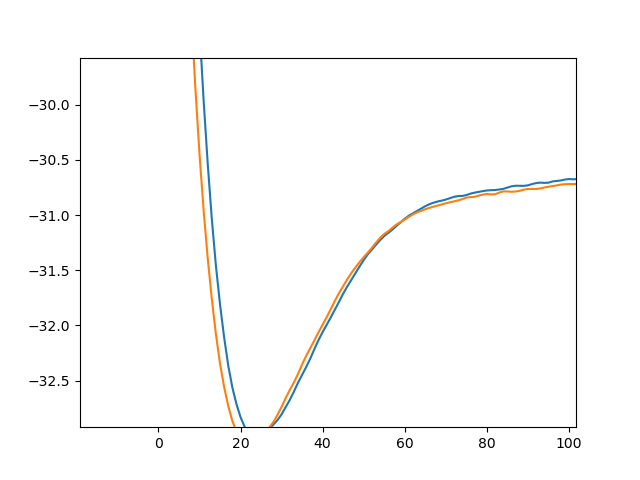

In [331]:
fig, ax = plt.subplots()

ax.plot(ds1_slice_0.tmpw)
ax.plot(ds1_slice_1.tmpw[::-1])

# try a cross correlation for the data of interest

In [333]:
ds1_int = ds1.sel(x=slice(0, 630))
ds1_rev = ds1_int.tmpw[::-1]

In [359]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


corr = signal.correlate(ds1_int.tmpw, ds1_rev)
lags = signal.correlation_lags(len(ds1_int.tmpw), len(ds1_rev))

<IPython.core.display.Javascript object>


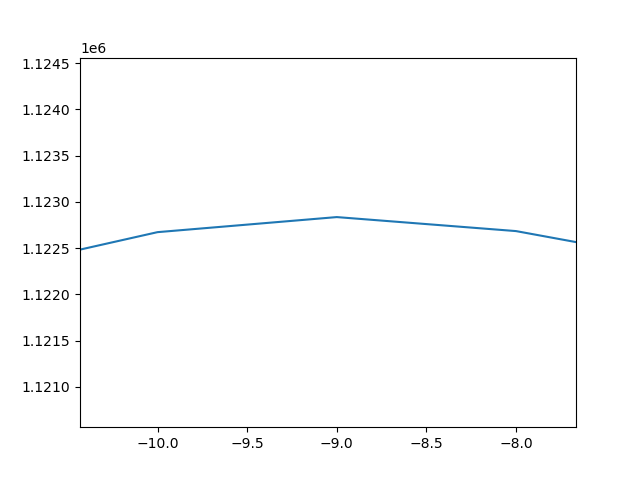

In [360]:
fig, ax = plt.subplots()

ax.plot(lags, corr)

In [345]:
print(list(corr).index(max(corr))*.254)

626.872


In [363]:
9*.254

2.286

In [379]:
ds_borehole_int = ds_borehole.sel(x=slice(0, 630))
ds_borehole_rev = ds_borehole_int.tmpw_avg2[::-1]

<IPython.core.display.Javascript object>


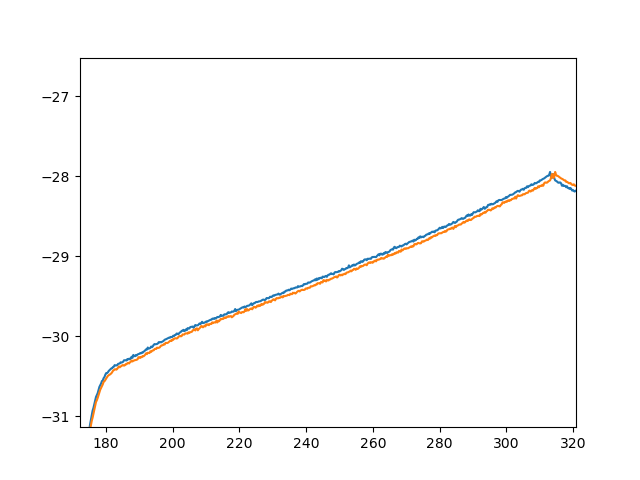

In [380]:
fig, ax = plt.subplots()

ax.plot(ds_borehole_int.x, ds_borehole_int.tmpw_avg2)
ax.plot(ds_borehole_int.x - 2.286, ds_borehole_rev)

In [801]:
ds_borehole_rev.sel(x=slice)

<xarray.DataArray 'tmpw_avg2' (x: 2478)>
dask.array<getitem, shape=(2478,), dtype=float64, chunksize=(2478,), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 629.8 629.5 629.3 629.0 ... 0.896 0.642 0.388 0.133

In [458]:
print(ds_borehole_int.tmpw_avg2.values)

[-7.95687623 -8.82872731 -9.02831615 ... -7.34392117 -7.340374
 -7.335651  ]


In [459]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [467]:
rolling_mean= moving_average(ds_borehole_int.tmpw_avg2.values, n=20)

In [780]:
print(len(rolling_mean))
print(len(ds_borehole_int.tmpw_avg2[5:-5]))

2469
2468


<IPython.core.display.Javascript object>


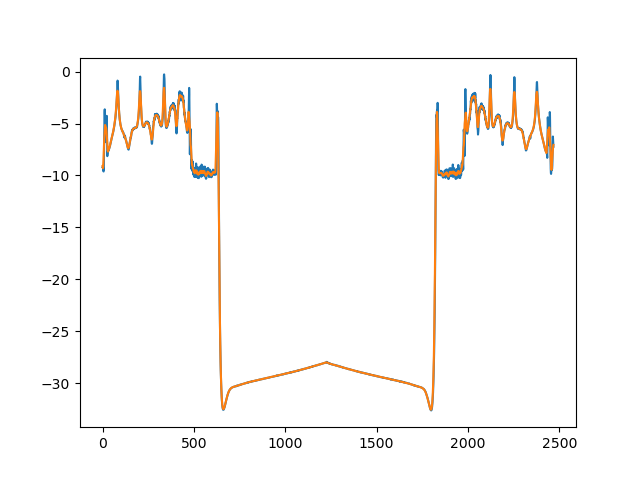

In [781]:
fig, ax = plt.subplots()

ax.plot(ds_borehole_int.tmpw_avg2[4:-5])
#ax.plot( ds_borehole_rev)
ax.plot(rolling_mean)


In [863]:
np.gradient(ds_borehole_int.sel(x=slice(180,312)).tmpw_avg2).mean()

0.004726806674397642

<IPython.core.display.Javascript object>


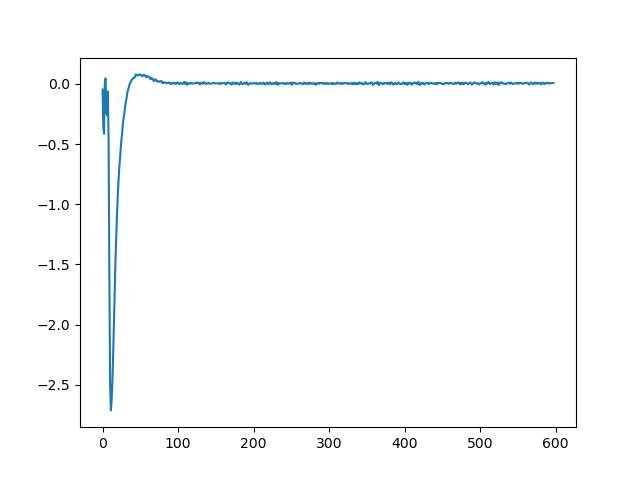

In [865]:
fig, ax = plt.subplots()

ax.plot(np.gradient(ds_borehole_int.sel(x=slice(160,312)).tmpw_avg2))


<module 'scipy' from '/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/scipy/__init__.py'>

In [823]:
import scipy

detrend1 = scipy.signal.detrend(ds_borehole_int.sel(x=slice(180,312)).tmpw_avg2)
detrend2 = scipy.signal.detrend(ds_borehole_int.sel(x=slice(316,448)).tmpw_avg2)


<IPython.core.display.Javascript object>


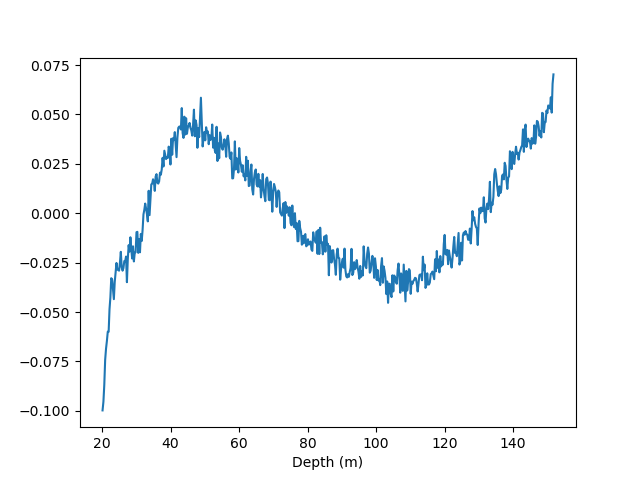

Text(0.5, 0, 'Depth (m)')

In [833]:
fig, ax = plt.subplots()

# ax.plot(ds_borehole_int.sel(x=slice(180,312)).x-160,detrend1)
# ax.plot(ds_borehole_int.sel(x=slice(316,448)).x-296,detrend2[::-1])

average = (detrend1 + detrend2[::-1]) / 2

ax.plot(ds_borehole_int.sel(x=slice(180,312)).x-160,average)

ax.set_xlabel('Depth (m)')

In [834]:
arr = np.array([detrend1, detrend2])

<IPython.core.display.Javascript object>


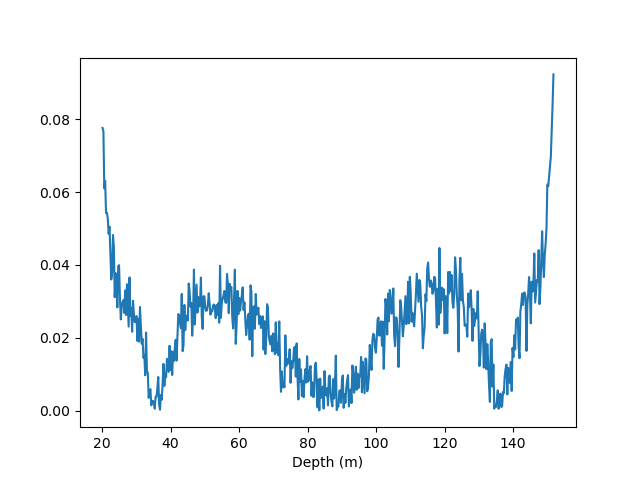

Text(0.5, 0, 'Depth (m)')

In [838]:
fig, ax = plt.subplots()

# ax.plot(ds_borehole_int.sel(x=slice(180,312)).x-160,detrend1)
# ax.plot(ds_borehole_int.sel(x=slice(316,448)).x-296,detrend2[::-1])

average = (detrend1 + detrend2[::-1]) / 2

ax.plot(ds_borehole_int.sel(x=slice(180,312)).x-160,np.std(arr, axis=0))

ax.set_xlabel('Depth (m)')



<IPython.core.display.Javascript object>


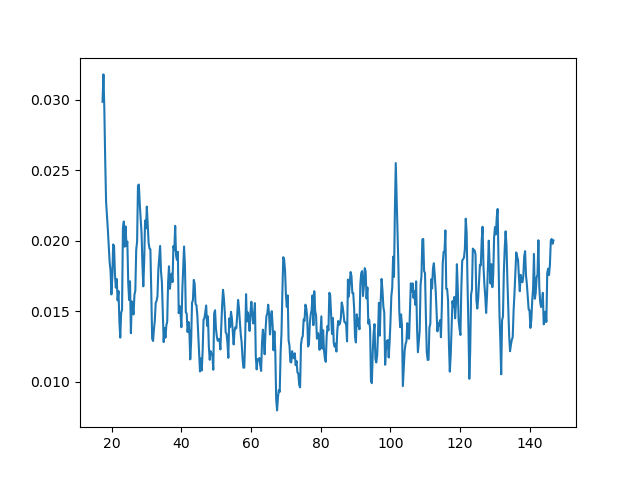

In [853]:
import pandas as pd

temp = pd.Series(ds_borehole_int.sel(x=slice(180,312)).tmpw_avg2)


fig, ax = plt.subplots()
ax.plot(ds_borehole_int.sel(x=slice(180,312)).x-165,temp.rolling(10).std())

In [859]:
interp = np.interp(np.arange(0,len(average),.005), np.arange(0,len(average),1), average)

<IPython.core.display.Javascript object>


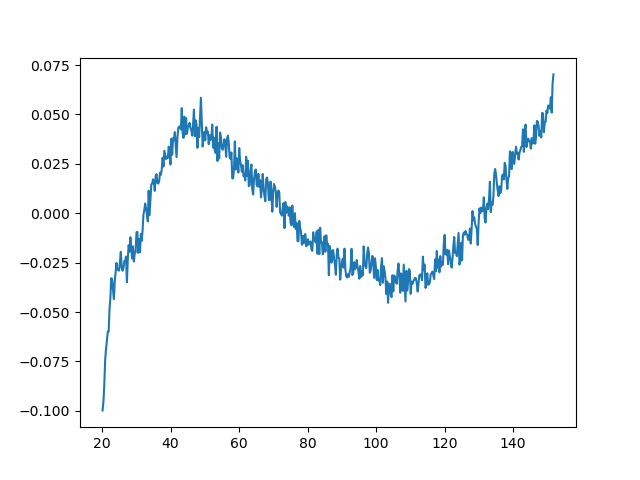

ValueError: x and y must have same first dimension, but have shapes (515,) and (103800,)

In [862]:
fig, ax = plt.subplots()

# ax.plot(ds_borehole_int.sel(x=slice(180,312)).x-160,detrend1)
# ax.plot(ds_borehole_int.sel(x=slice(316,448)).x-296,detrend2[::-1])

average = (detrend1 + detrend2[::-1]) / 2

ax.plot(ds_borehole_int.sel(x=slice(180,312)).x-160,average)
ax.plot(np.arange((ds_borehole_int.sel(x=slice(180,312)).x-160)[0], (ds_borehole_int.sel(x=slice(180,312)).x-160)[-1], .256),interp)

ax.set_xlabel('Depth (m)')

In [773]:
b, a = scipy.signal.butter(4, [1/50,1/100], btype='bandpass', analog=True)
y = signal.filtfilt(b, a, detrend,  method='gust')


<IPython.core.display.Javascript object>


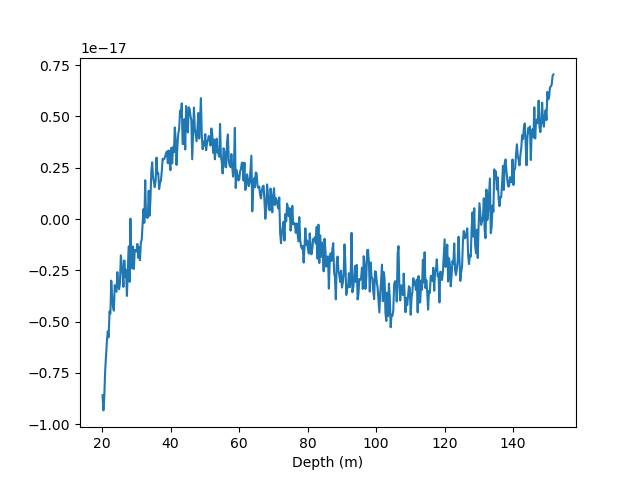

Text(0.5, 0, 'Depth (m)')

In [774]:
fig, ax = plt.subplots()

ax.plot(ds_borehole_int.sel(x=slice(180,312)).x-160, y)
ax.set_xlabel('Depth (m)')

<IPython.core.display.Javascript object>


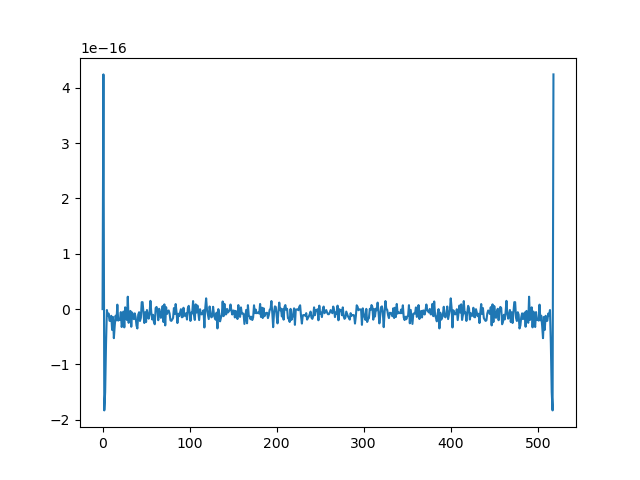

In [779]:
yf = scipy.fft.fft(y)

fig, ax = plt.subplots()

ax.plot(yf)

In [51]:
import glob
import pandas as pd
files_temp = glob.glob('AWS_temp/*')
times = []
temps = []
for i in files_temp:
    data = pd.read_csv(i, delimiter='\t')  
    for ii,jj in zip(data['DateTime UTC    '].values, data['Temp'].values):
        times.append(ii)
        temps.append(jj)

In [56]:
temps[temps == 'Null'] = np.nan

In [58]:
temps = temps.astype(float)

In [85]:
from scipy import signal
sos = signal.butter(10, .000001, 'lp', fs=1/3600, output='sos')
filtered = signal.sosfilt(sos, temps)

(0.0, 10000.0)

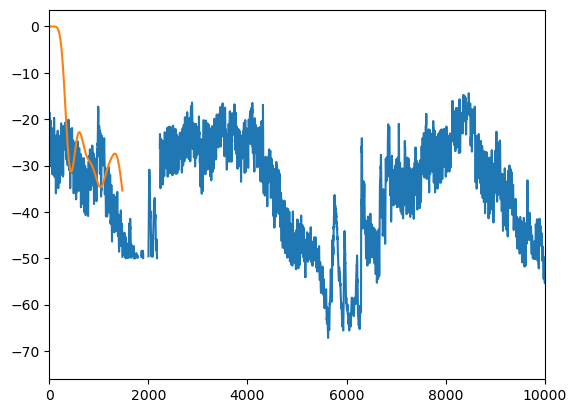

In [86]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(temps)
ax.plot(filtered)
ax.set_xlim([0,10000])

In [88]:
import numpy as np

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


In [91]:
nans, x = nan_helper(temps)
temps[nans]= np.interp(x(nans), x(~nans), temps[~nans])

In [ ]:
from scipy import signal
sos = signal.butter(10, .000000005, 'lp', fs=1/3600, output='sos')
filtered = signal.sosfilt(sos, temps)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n




import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times,temps)
ax.plot(filtered)
ax.plot(moving_average(temps, n=10000))